In [1]:
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Dropout,
    BatchNormalization,
    Activation,
    Add,
    Dense,
    GlobalAveragePooling1D,
)
import keras.backend as K
# from easydl import clear_output
from sklearn.utils import shuffle

# from get_representations import *

# 这次试验的思路是
# 第一步 数据处理 提取出ECG和对应标签，将5000降采样到2048，保存
# 第二步 对每个个体定义test，val，train数据集的部分，比例为0:9:1，个体的每条数据调整为10s，即4096个点，
# 第三步 导入PCLR预训练模型，学习率0.001，mse，耐心50，epoch400，训练
# 第四步 使用BHS等验证模型效果
# ……


In [4]:
def normalization(train,val):
    """对三个数据集统一归一化后，返回"""
    
    alldata = np.zeros((1,4096))
    alldata = np.vstack((alldata,train))
    alldata = np.vstack((alldata,val))
#     alldata = np.vstack((alldata,test))
    
#     归一化
    ma = alldata.max()
    mi = alldata.min()
    alldata = (alldata-mi)/(ma-mi)
    
    print(ma)
    print(mi)
    s1 = train.shape[0]
    s2 = val.shape[0]
#     s3 = test.shape[0]
     
#     return alldata[1:s1+1],alldata[s1+1:s1+s2+1],alldata[s1+s2+1:]
    return alldata[1:s1+1],alldata[s1+1:s1+s2+1]

In [2]:
def load(index):
#           (xxxx,4096)
    ecg = np.load('/data/drink/ECG/{}.npy'.format(index))
#           (xxxx,2)
    label = np.load('/data/drink/label/label{}.npy'.format(index))

    ECG10 = []
    for i in range(int(ecg.shape[0]/2)):
        ECG10.append(np.concatenate([ecg[2*i],ecg[2*i+1]]))

    LABEL4 = []
    for i in range(int(label.shape[0]/2)):
        LABEL4.append(np.concatenate([label[2*i],label[2*i+1]]))

    return shuffle(ECG10[1:],LABEL4[1:],random_state=666)
#     return ECG10[1:],LABEL4[1:]

# 22开始 22-25 和 1-7 是没有归一化训练的
index = 25
ecg,label = load(index)
ecg = np.array(ecg)
label = np.array(label)
# longth = ecg.shape[0]

NameError: name 'np' is not defined

In [36]:
train_longth = int(ecg.shape[0]/10)

ECG_train = ecg[:train_longth]
ECG_val = ecg[train_longth:]
LABEL_train = label[:train_longth]
LABEL_val = label[train_longth:]

ECG_train.shape

(119, 4096)

In [38]:
ECG_train,ECG_val = normalization(ECG_train,ECG_val)
ECG_val.max()
# ECG_train.shape

1.9342930900688238
0.0


1.0

In [39]:
# np.where(ECG_train==ECG_train.max())

In [40]:
# # 检查
# plt.plot(ECG_train[10])
# ECG_train.max()

In [41]:
# ECG_train,LABEL_train = shuffle(ECG_train,LABEL_train)

In [4]:
# plt.plot(ECG_train[63], label='label') 
# plt.legend()
pclr = load_model('/home/ubuntu/ml4h/ml4h/model_zoo/PCLR/zml/PCLR_lead_I.h5')
pclr.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg (InputLayer)               [(None, 4096, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4096, 64)     1024        ['ecg[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 4096, 64)     0           ['batch_normalization[

In [43]:


length = 32
model = tf.keras.models.Sequential()
model.add(pclr) # 记得改模型名称
model.add(Dense(length*10,activation='relu'))
model.add(Dense(length*5,activation='relu'))
model.add(Dense(length,activation='relu'))
model.add(Dense(4)) # sbp dbp
model.layers[0].trainable = False
model.summary()

# monitor:监视参数，min_delta:小于此数认为不变化，mode:loss小好，acc大好，patience:n周期无提升则退出，restore_best_weights:取最优权重
earlyStop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=100,
                          mode='min', 
                          verbose=1, 
                          restore_best_weights = True)

length = 32
epoch=300
batch_size=8
lr = 0.001
tp='mse'
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss=tp)

model_name = '/data/drink/e_result/10/'+str(index)+'&320-160-32-4-{epoch:03d}-{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath=model_name, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_best_value=True,
                             initial_value_threshold=150)

callback_list = [earlyStop, checkpoint]



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 functional_1 (Functional)   (None, 320)               6383648   
                                                                 
 dense_12 (Dense)            (None, 320)               102720    
                                                                 
 dense_13 (Dense)            (None, 160)               51360     
                                                                 
 dense_14 (Dense)            (None, 32)                5152      
                                                                 
 dense_15 (Dense)            (None, 4)                 132       
                                                                 
Total params: 6,543,012
Trainable params: 159,364
Non-trainable params: 6,383,648
_________________________________________________________________


In [44]:
h = model.fit(ECG_train,LABEL_train, 
              validation_data=(ECG_val,LABEL_val), 
              epochs=epoch, 
              batch_size=batch_size, 
              shuffle=True, 
              verbose=1,
              callbacks=callback_list
             )

Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 9460.8418 
Epoch 00001: val_loss improved from inf to 3134.34131, saving model to /data/drink/e_result/10/25&320-160-32-4-001-3134.34.h5
15/15 [==============================] - 3s 98ms/step - loss: 9460.8418 - val_loss: 3134.3413
Epoch 2/300
 9/15 [=================>............] - ETA: 0s - loss: 1655.2039
Epoch 00002: val_loss improved from 3134.34131 to 231.01755, saving model to /data/drink/e_result/10/25&320-160-32-4-002-231.02.h5
15/15 [==============================] - 1s 69ms/step - loss: 1411.5260 - val_loss: 231.0175
Epoch 3/300
 9/15 [=================>............] - ETA: 0s - loss: 183.6273
Epoch 00003: val_loss improved from 231.01755 to 135.06686, saving model to /data/drink/e_result/10/25&320-160-32-4-003-135.07.h5
15/15 [==============================] - 1s 70ms/step - loss: 205.4368 - val_loss: 135.0669
Epoch 4/300
 9/15 [=================>............] - ETA: 0s - loss: 141.6418
Epoch 00004: val_lo

 9/15 [=================>............] - ETA: 0s - loss: 48.5596
Epoch 00032: val_loss did not improve from 45.54168
15/15 [==============================] - 1s 62ms/step - loss: 47.1170 - val_loss: 51.1546
Epoch 33/300
 9/15 [=================>............] - ETA: 0s - loss: 47.3703
Epoch 00033: val_loss improved from 45.54168 to 45.19568, saving model to /data/drink/e_result/10/25&320-160-32-4-033-45.20.h5
15/15 [==============================] - 1s 69ms/step - loss: 48.0457 - val_loss: 45.1957
Epoch 34/300
 9/15 [=================>............] - ETA: 0s - loss: 37.8501
Epoch 00034: val_loss improved from 45.19568 to 43.20024, saving model to /data/drink/e_result/10/25&320-160-32-4-034-43.20.h5
15/15 [==============================] - 1s 69ms/step - loss: 43.7398 - val_loss: 43.2002
Epoch 35/300
 9/15 [=================>............] - ETA: 0s - loss: 36.1040
Epoch 00035: val_loss did not improve from 43.20024
15/15 [==============================] - 1s 63ms/step - loss: 43.2744 - v

Epoch 66/300
 8/15 [===============>..............] - ETA: 0s - loss: 21.4775
Epoch 00066: val_loss did not improve from 31.75443
15/15 [==============================] - 1s 62ms/step - loss: 22.3982 - val_loss: 33.9807
Epoch 67/300
 9/15 [=================>............] - ETA: 0s - loss: 23.5677
Epoch 00067: val_loss did not improve from 31.75443
15/15 [==============================] - 1s 63ms/step - loss: 25.1965 - val_loss: 35.2653
Epoch 68/300
 9/15 [=================>............] - ETA: 0s - loss: 20.9910
Epoch 00068: val_loss improved from 31.75443 to 31.17384, saving model to /data/drink/e_result/10/25&320-160-32-4-068-31.17.h5
15/15 [==============================] - 1s 69ms/step - loss: 23.5176 - val_loss: 31.1738
Epoch 69/300
 9/15 [=================>............] - ETA: 0s - loss: 22.9058
Epoch 00069: val_loss did not improve from 31.17384
15/15 [==============================] - 1s 63ms/step - loss: 21.3902 - val_loss: 36.4268
Epoch 70/300
 9/15 [=================>.......

Epoch 102/300
 9/15 [=================>............] - ETA: 0s - loss: 11.5061
Epoch 00102: val_loss did not improve from 29.32123
15/15 [==============================] - 1s 63ms/step - loss: 13.7194 - val_loss: 29.6262
Epoch 103/300
 9/15 [=================>............] - ETA: 0s - loss: 17.0837
Epoch 00103: val_loss did not improve from 29.32123
15/15 [==============================] - 1s 62ms/step - loss: 14.9975 - val_loss: 30.0820
Epoch 104/300
 9/15 [=================>............] - ETA: 0s - loss: 13.9670
Epoch 00104: val_loss did not improve from 29.32123
15/15 [==============================] - 1s 62ms/step - loss: 14.7690 - val_loss: 32.2598
Epoch 105/300
 9/15 [=================>............] - ETA: 0s - loss: 12.2961
Epoch 00105: val_loss did not improve from 29.32123
15/15 [==============================] - 1s 62ms/step - loss: 14.9285 - val_loss: 30.6455
Epoch 106/300
 9/15 [=================>............] - ETA: 0s - loss: 15.8214
Epoch 00106: val_loss did not improve

 8/15 [===============>..............] - ETA: 0s - loss: 9.2127 
Epoch 00176: val_loss did not improve from 29.32123
15/15 [==============================] - 1s 62ms/step - loss: 9.8814 - val_loss: 31.5684
Epoch 177/300
 9/15 [=================>............] - ETA: 0s - loss: 11.1261
Epoch 00177: val_loss did not improve from 29.32123
15/15 [==============================] - 1s 62ms/step - loss: 11.0897 - val_loss: 33.9008
Epoch 178/300
 9/15 [=================>............] - ETA: 0s - loss: 11.0154
Epoch 00178: val_loss did not improve from 29.32123
15/15 [==============================] - 1s 62ms/step - loss: 10.9552 - val_loss: 32.6790
Epoch 179/300
 9/15 [=================>............] - ETA: 0s - loss: 9.0047
Epoch 00179: val_loss did not improve from 29.32123
15/15 [==============================] - 1s 62ms/step - loss: 10.5567 - val_loss: 31.4879
Epoch 180/300
 9/15 [=================>............] - ETA: 0s - loss: 8.6558 
Epoch 00180: val_loss did not improve from 29.32123
1

dict_keys(['loss', 'val_loss'])


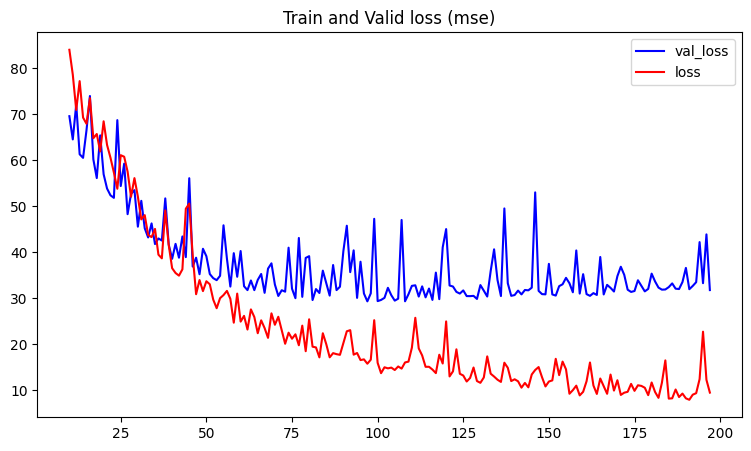

In [45]:
history = h.history
print(history.keys())
epochs = range(len(history['loss']))

plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 2, 1)
ax.set_title('Train and Valid loss (mse)')
plt.plot(epochs[10:], history['val_loss'][10:], 'b', label='val_loss')
plt.plot(epochs[10:], history['loss'][10:], 'r', label='loss')
plt.savefig('./img/{index} loss.png'.format(index=index))
plt.legend()

 # 验证

In [41]:
m = load_model('/data/drink/e_result/10/25&320-160-32-4-098-29.32.h5')
index = 25
# 18  25

In [42]:
def load(index):
#           (xxxx,4096)
    ecg = np.load('/data/drink/ECG/{}.npy'.format(index))
#           (xxxx,2)
    label = np.load('/data/drink/label/label{}.npy'.format(index))

    ECG10 = []
    for i in range(int(ecg.shape[0]/2)):
        ECG10.append(np.concatenate([ecg[2*i],ecg[2*i+1]]))

    LABEL4 = []
    for i in range(int(label.shape[0]/2)):
        LABEL4.append(np.concatenate([label[2*i],label[2*i+1]]))

#     return shuffle(ECG10[1:],LABEL4[1:],random_state=666)
    return ECG10[1:],LABEL4[1:]
# 22开始

ecg,label = load(index)
ecg = np.array(ecg)
label = np.array(label)
val_longth = ecg.shape[0]-int(ecg.shape[0]/10)


train_longth = int(ecg.shape[0]/10)
ECG_train = ecg[:train_longth]
ECG_val = ecg[train_longth:]
LABEL_train = label[:train_longth]
LABEL_val = label[train_longth:]

ECG_train.shape

ECG_train,ECG_val = normalization(ECG_train,ECG_val)

1.9342930900688238
0.0


In [43]:
res = m.predict(ECG_val)
# print(res[0])
# print(LABEL_val[0])
# print(res.shape)

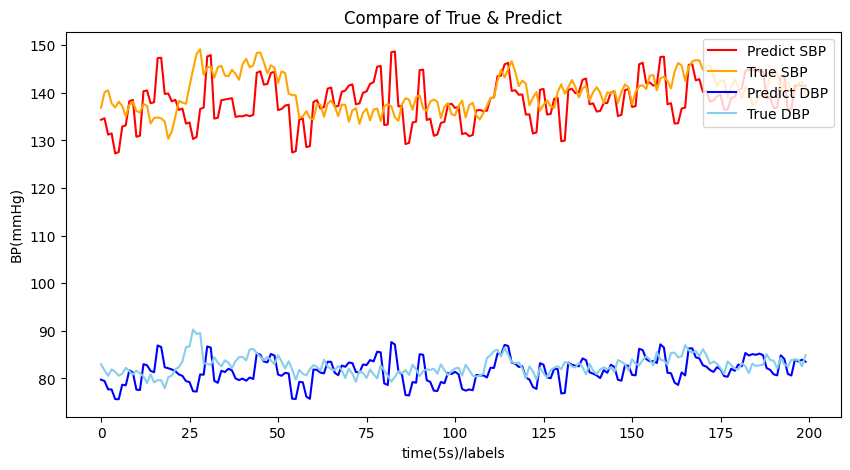

In [44]:
# 时序图 需要把10s的标签展开成5s的
def unfold(d2array,tp=0):
#     tp=0 提取dbp，tp=1提取sbp
    r = []
    for i in d2array:
        r.append(i[0 if tp else 1])
        r.append(i[2 if tp else 3])
    return r

res_d = unfold(res,0)
res_s = unfold(res,1)
lab_d = unfold(LABEL_val,0)
lab_s = unfold(LABEL_val,1)
    
plt.figure(figsize=(10, 5))
plt.title('Compare of True & Predict')
plt.plot(res_s[300:500], 'r', label='Predict SBP')
plt.plot(lab_s[300:500], 'orange', label='True SBP')
plt.plot(res_d[300:500], 'b', label='Predict DBP')
plt.plot(lab_d[300:500], 'skyblue', label='True DBP')
plt.xlabel('time(5s)/labels')
plt.ylabel('BP(mmHg)')
plt.legend(loc=1)
plt.savefig("./img/compare/Compare{:0>2d}.png".format(index))

# plt.plot(res[2], 'm', label='Predict DBP')
# plt.plot(res[3], 'g', label='True DBP')

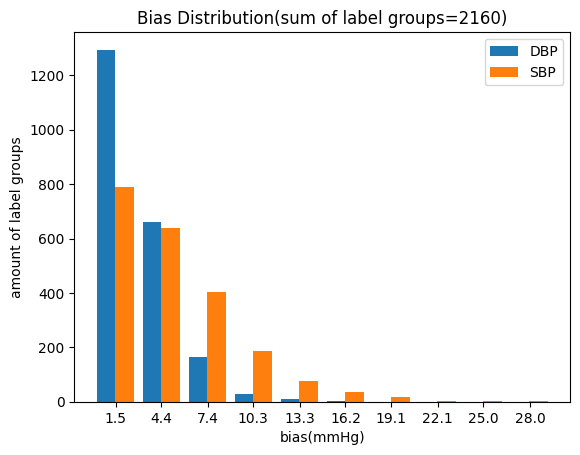

In [45]:
# 偏差分布图
differ = abs(res-LABEL_val)

bias_d = unfold(differ,0)
bias_s = unfold(differ,1)
# lab_d = unfold(LABEL_val,0)
# lab_s = unfold(LABEL_val,1)

plt.title('Bias Distribution(sum of label groups='+str(val_longth*2)+')')
# plt.text(30,100 , 'sum='+str(val_longth), fontdict=None)
sth = plt.hist([bias_d,bias_s],
         label=['DBP','SBP'],
#          color=['indianred','lightcoral','deepskyblue','skyblue'],
#          cplor=['indianred']
#          histtype='barstacked'
        )
# 获取x坐标，换掉
j = 0
x_ticks = []
for i in sth[1]:
    x_ticks.append(round((i+j)/2,1))
    j=i

plt.xticks(x_ticks[1:])
plt.xlabel('bias(mmHg)')
plt.ylabel('amount of label groups')
plt.legend(loc=1)
plt.savefig("./img/distribution/Bias Distribution({longth}){index:0>2d}.png".format(index=index,longth=val_longth*2))

In [46]:
all_res = []
all_lab = []
all_res.append(np.concatenate([res_s,res_d]))
all_lab.append(np.concatenate([lab_s,lab_d]))

x = np.array([])
for i in all_lab:
    x = np.hstack((x,i))


y = np.array([])
for j in all_res:
    y = np.hstack((y,j))
    
print(y.shape)
print(x.shape)

(4320,)
(4320,)


In [47]:
# BA图
import pyCompare
pyCompare.blandAltman(x,
                      y, 
                      percentage=False, 
                      title='Bland-Altman Plot',
                      savePath='./img/BAFigure{:0>2d}.png'.format(index),
                      limitOfAgreement=1.96)

In [48]:
def BHS_standard(predict, test):
    total = len(predict[0])
    mm5 = np.sum(np.abs(predict-test)<=5.0)
    mm10 = np.sum(np.abs(predict-test)<=10.0)
    mm15 = np.sum(np.abs(predict-test)<=15.0)
    return total, mm5, mm10, mm15

# t_data = tf.transpose(test_label,(1,0))
# predict_data = tf.transpose(res,(1,0))
# predict_data.dtype # 检查数据类型，发现predict是float32，label是float64
# predict_data = tf.cast(predict_data,dtype='float64') 

total, mm5, mm10, mm15 = BHS_standard(np.array(all_res),np.array(all_lab))
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))


-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
3112            4059           4265          4320
72.037%        93.958%       98.727%         4320


In [49]:
def AAMI_standard(predict, test):
    total = len(predict[0])
    ME = np.mean(predict - test)
    MAE = np.mean(np.abs(predict-test))
    SD = np.std(predict-test)
    return total, ME, MAE, SD

def AAMI(res,test):
    total, ME, MAE, SD = AAMI_standard(res, test)
    print()
    print('-------------AAMI standard------------')
    print('ME            MAE         SD          total')
    print('%.3f        %.3f       %.3f       %d'%(ME,MAE,SD,total))
    
    return total, ME, MAE, SD

AAMI(np.array(all_res),np.array(all_lab)) #SBP


-------------AAMI standard------------
ME            MAE         SD          total
-0.314        3.910       5.194       4320


(4320, -0.31354196689690567, 3.9098175495205885, 5.193832964247488)